## Example Honor: Credit to Abhijith Dasharathi

# Honor Code Project

First lets do setup for google colab.

In [11]:
! wget https://raw.githubusercontent.com/hse-aml/natural-language-processing/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab
# please, uncomment the week you're working on
# setup_google_colab.setup_week1()  
# setup_google_colab.setup_week2()
# setup_google_colab.setup_week3()
# setup_google_colab.setup_week4()
# setup_google_colab.setup_project()
setup_google_colab.setup_honor()

--2019-10-16 04:46:09--  https://raw.githubusercontent.com/hse-aml/natural-language-processing/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2330 (2.3K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   2.28K  --.-KB/s    in 0s      

2019-10-16 04:46:10 (28.3 MB/s) - ‘setup_google_colab.py’ saved [2330/2330]



Now lets test what all we have

In [14]:
!ls

common	     download_cornell.sh   example.py	sample_data
datasets.py  download_opensubs.sh  __pycache__	setup_google_colab.py


**Download Data**

Make the scripts executable

In [0]:
!chmod +x download_cornell.sh
!chmod +x download_opensubs.sh

Run scripts to download data

In [16]:
!./download_cornell.sh

--2019-10-16 04:49:52--  https://github.com/Conchylicultor/DeepQA/raw/master/data/cornell/movie_conversations.txt
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Conchylicultor/DeepQA/master/data/cornell/movie_conversations.txt [following]
--2019-10-16 04:49:52--  https://raw.githubusercontent.com/Conchylicultor/DeepQA/master/data/cornell/movie_conversations.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6760930 (6.4M) [text/plain]
Saving to: ‘movie_conversations.txt’

movie_conversations 100%[===================>]   6.45M  --.-KB/s    in 0.06s   

2019-10-16 04:49:52 (112 MB/s) - ‘movie_convers

In [17]:
%%writefile download_opensubs.sh
#!/bin/bash

mkdir -p data/opensubs
cd data/opensubs
wget -O en.tar.gz http://opus.lingfil.uu.se/download.php?f=OpenSubtitles/en.tar.gz
unzip en.tar.gz
rm en.tar.gz


Overwriting download_opensubs.sh


In [18]:
!./download_opensubs.sh

--2019-10-16 04:50:07--  http://opus.lingfil.uu.se/download.php?f=OpenSubtitles/en.tar.gz
Resolving opus.lingfil.uu.se (opus.lingfil.uu.se)... 130.238.78.148
Connecting to opus.lingfil.uu.se (opus.lingfil.uu.se)|130.238.78.148|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://opus.nlpl.eu/download.php?f=OpenSubtitles/en.tar.gz [following]
--2019-10-16 04:50:07--  http://opus.nlpl.eu/download.php?f=OpenSubtitles/en.tar.gz
Resolving opus.nlpl.eu (opus.nlpl.eu)... 193.166.25.9
Connecting to opus.nlpl.eu (opus.nlpl.eu)|193.166.25.9|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://object.pouta.csc.fi/OPUS-OpenSubtitles/v1/xml/en.zip [following]
--2019-10-16 04:50:07--  https://object.pouta.csc.fi/OPUS-OpenSubtitles/v1/xml/en.zip
Resolving object.pouta.csc.fi (object.pouta.csc.fi)... 86.50.254.18
Connecting to object.pouta.csc.fi (object.pouta.csc.fi)|86.50.254.18|:443... connected.
HTTP request sent, awaitin

In [19]:
!ls data/opensubs/OpenSubtitles/

xml


Updating datasets.py

In [20]:
%%writefile datasets.py
# Copyright 2015 Conchylicultor. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

import ast
import os
import random
import re
from time import time

import nltk
from tqdm import tqdm

"""
Load the cornell movie dialog corpus.
Available from here:
http://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html
"""

class CornellData:
    """
    """

    def __init__(self, dirName):
        """
        Args:
            dirName (string): directory where to load the corpus
        """
        self.lines = {}
        self.conversations = []

        MOVIE_LINES_FIELDS = ["lineID","characterID","movieID","character","text"]
        MOVIE_CONVERSATIONS_FIELDS = ["character1ID","character2ID","movieID","utteranceIDs"]

        self.lines = self.loadLines(os.path.join(dirName, "movie_lines.txt"), MOVIE_LINES_FIELDS)
        self.conversations = self.loadConversations(os.path.join(dirName, "movie_conversations.txt"), MOVIE_CONVERSATIONS_FIELDS)

        # TODO: Cleaner program (merge copy-paste) !!

    def loadLines(self, fileName, fields):
        """
        Args:
            fileName (str): file to load
            field (set<str>): fields to extract
        Return:
            dict<dict<str>>: the extracted fields for each line
        """
        lines = {}

        with open(fileName, 'r', encoding='iso-8859-1') as f:  # TODO: Solve Iso encoding pb !
            for line in f:
                values = line.split(" +++$+++ ")

                # Extract fields
                lineObj = {}
                for i, field in enumerate(fields):
                    lineObj[field] = values[i]

                lines[lineObj['lineID']] = lineObj

        return lines

    def loadConversations(self, fileName, fields):
        """
        Args:
            fileName (str): file to load
            field (set<str>): fields to extract
        Return:
            list<dict<str>>: the extracted fields for each line
        """
        conversations = []

        with open(fileName, 'r', encoding='iso-8859-1') as f:  # TODO: Solve Iso encoding pb !
            for line in f:
                values = line.split(" +++$+++ ")

                # Extract fields
                convObj = {}
                for i, field in enumerate(fields):
                    convObj[field] = values[i]

                # Convert string to list (convObj["utteranceIDs"] == "['L598485', 'L598486', ...]")
                lineIds = ast.literal_eval(convObj["utteranceIDs"])

                # Reassemble lines
                convObj["lines"] = []
                for lineId in lineIds:
                    convObj["lines"].append(self.lines[lineId])

                conversations.append(convObj)

        return conversations

    def getConversations(self):
        return self.conversations


# Based on code from https://github.com/AlJohri/OpenSubtitles
# by Al Johri <al.johri@gmail.com>

import xml.etree.ElementTree as ET
import datetime
import os
import sys
import json
import re
import pprint

from gzip import GzipFile

"""
Load the opensubtitles dialog corpus.
"""

class OpensubsData:
    """
    """

    def __init__(self, dirName):
        """
        Args:
            dirName (string): directory where to load the corpus
        """

        # Hack this to filter on subset of Opensubtitles
        # dirName = "%s/en/Action" % dirName

        print("Loading OpenSubtitles conversations in %s." % dirName)
        self.conversations = []
        self.tag_re = re.compile(r'(<!--.*?-->|<[^>]*>)')
        self.conversations = self.loadConversations(dirName)

    def loadConversations(self, dirName):
        """
        Args:
            dirName (str): folder to load
        Return:
            array(question, answer): the extracted QA pairs
        """
        conversations = []
        dirList = self.filesInDir(dirName)
        for filepath in tqdm(dirList, "OpenSubtitles data files"):
            if filepath.endswith('xml'):
                try:
                    doc = self.getXML(filepath)
                    conversations.extend(self.genList(doc))
                except ValueError:
                    tqdm.write("Skipping file %s with errors." % filepath)
                except:
                    print("Unexpected error:", sys.exc_info()[0])
                    raise
        return conversations

    def getConversations(self):
        return self.conversations

    def genList(self, tree):
        root = tree.getroot()

        timeFormat = '%H:%M:%S'
        maxDelta = datetime.timedelta(seconds=1)

        startTime = datetime.datetime.min
        strbuf = ''
        sentList = []

        for child in root:
            for elem in child:
                if elem.tag == 'time':
                    elemID = elem.attrib['id']
                    elemVal = elem.attrib['value'][:-4]
                    if elemID[-1] == 'S':
                        startTime = datetime.datetime.strptime(elemVal, timeFormat)
                    else:
                        sentList.append((strbuf.strip(), startTime, datetime.datetime.strptime(elemVal, timeFormat)))
                        strbuf = ''
                else:
                    try:
                        strbuf = strbuf + " " + elem.text
                    except:
                        pass

        conversations = []
        for idx in range(0, len(sentList) - 1):
            cur = sentList[idx]
            nxt = sentList[idx + 1]
            if nxt[1] - cur[2] <= maxDelta and cur and nxt:
                tmp = {}
                tmp["lines"] = []
                tmp["lines"].append(self.getLine(cur[0]))
                tmp["lines"].append(self.getLine(nxt[0]))
                if self.filter(tmp):
                    conversations.append(tmp)

        return conversations

    def getLine(self, sentence):
        line = {}
        line["text"] = self.tag_re.sub('', sentence).replace('\\\'','\'').strip().lower()
        return line

    def filter(self, lines):
        # Use the followint to customize filtering of QA pairs
        #
        # startwords = ("what", "how", "when", "why", "where", "do", "did", "is", "are", "can", "could", "would", "will")
        # question = lines["lines"][0]["text"]
        # if not question.endswith('?'):
        #     return False
        # if not question.split(' ')[0] in startwords:
        #     return False
        #
        return True

    def getXML(self, filepath):
        fext = os.path.splitext(filepath)[1]
        if fext == '.gz':
            tmp = GzipFile(filename=filepath)
            return ET.parse(tmp)
        else:
            return ET.parse(filepath)

    def filesInDir(self, dirname):
        result = []
        for dirpath, dirs, files in os.walk(dirname):
            for filename in files:
                fname = os.path.join(dirpath, filename)
                result.append(fname)
        return result


def extractText(line, fast_preprocessing=True):
    if fast_preprocessing:
        GOOD_SYMBOLS_RE = re.compile('[^0-9a-z ]')
        REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;#+_]')
        REPLACE_SEVERAL_SPACES = re.compile('\s+')

        line = line.lower()
        line = REPLACE_BY_SPACE_RE.sub(' ', line)
        line = GOOD_SYMBOLS_RE.sub('', line)
        line = REPLACE_SEVERAL_SPACES.sub(' ', line)
        return line.strip()
    else:
        return nltk.word_tokenize(line)


def splitConversations(conversations, max_len=20, fast_preprocessing=True):
    data = []
    for i, conversation in enumerate(tqdm(conversations)):
        lines = conversation['lines']
        for i in range(len(lines) - 1):
            request = extractText(lines[i]['text'])
            reply = extractText(lines[i + 1]['text'])
            if 0 < len(request) <= max_len and 0 < len(reply) <= max_len:
                data += [(request, reply)]
    return data


def readCornellData(path, max_len=20, fast_preprocessing=True):
    dataset = CornellData(path)
    conversations = dataset.getConversations()
    return splitConversations(conversations, max_len=max_len, fast_preprocessing=fast_preprocessing)


def readOpensubsData(path, max_len=20, fast_preprocessing=True):
    dataset = OpensubsData(path)
    conversations = dataset.getConversations()
    return splitConversations(conversations, max_len=max_len, fast_preprocessing=fast_preprocessing)

Overwriting datasets.py


Testing the data

In [21]:
!python3 example.py cornell

100% 83097/83097 [00:03<00:00, 24499.70it/s]
Size of dataset: 5256
First 10 training pairs:
('there', 'where')
('wow', 'lets go')
('she okay', 'i hope so')
('who', 'joey')
('its more', 'expensive')
('thirtytwo', 'get out')
('okay', 'im fine im')
('sure i do', 'why')
('who', 'dorsey')
('dorsey', 'i hate him')


In [22]:
!python3 example.py opensubs

Loading OpenSubtitles conversations in data/opensubs.
Skipping file data/opensubs/OpenSubtitles/xml/en/Family/2001/3935_19508_22105_cats__dogs.xml with errors.
Skipping file data/opensubs/OpenSubtitles/xml/en/Action/2004/59_84873_113518_appurushdo.xml with errors.
Skipping file data/opensubs/OpenSubtitles/xml/en/Action/2003/602_152466_207871_batoru_rowaiaru_ii_rekuiemu.xml with errors.
Skipping file data/opensubs/OpenSubtitles/xml/en/Drama/2004/146_206647_272090_eternal_sunshine_of_the_spotless_mind.xml with errors.
Skipping file data/opensubs/OpenSubtitles/xml/en/Drama/2002/3265_149497_204017_unfaithful.xml with errors.
Skipping file data/opensubs/OpenSubtitles/xml/en/Drama/2000/179_88528_119102_batoru_rowaiaru.xml with errors.
Skipping file data/opensubs/OpenSubtitles/xml/en/Drama/2003/1723_68784_89159_big_fish.xml with errors.
Skipping file data/opensubs/OpenSubtitles/xml/en/Horror/1922/1166_134135_184270_nosferatu_eine_symphonie_des_grauens.xml with errors.
Skipping file data/opens

# Now Lets create the data for training and save in tsv file

In [23]:
import datasets
import os
import csv

cornell_dataset_path = os.path.join("data", "cornell")
opensubs_dataset_path = os.path.join("data", "opensubs")
cornelldata = datasets.readCornellData(cornell_dataset_path, max_len=10)
opensubsdata = datasets.readOpensubsData(opensubs_dataset_path, max_len=10)
data = cornelldata + opensubsdata
with open('data/preparedTrain.tsv', 'wt') as out_file:
    tsv_writer = csv.writer(out_file, delimiter='\t')
    for item in data:
      tsv_writer.writerow([item[0], item[1]])

OpenSubtitles data files:   0%|          | 0/4637 [00:00<?, ?it/s]

Loading OpenSubtitles conversations in data/opensubs.


OpenSubtitles data files:   1%|          | 26/4637 [00:01<03:16, 23.44it/s]

Skipping file data/opensubs/OpenSubtitles/xml/en/Family/2001/3935_19508_22105_cats__dogs.xml with errors.


OpenSubtitles data files:  31%|███       | 1432/4637 [00:58<01:54, 28.04it/s]

Skipping file data/opensubs/OpenSubtitles/xml/en/Action/2004/59_84873_113518_appurushdo.xml with errors.


OpenSubtitles data files:  41%|████▏     | 1916/4637 [01:17<02:01, 22.35it/s]

Skipping file data/opensubs/OpenSubtitles/xml/en/Action/2003/602_152466_207871_batoru_rowaiaru_ii_rekuiemu.xml with errors.


OpenSubtitles data files:  53%|█████▎    | 2447/4637 [01:36<00:59, 36.64it/s]

Skipping file data/opensubs/OpenSubtitles/xml/en/Drama/2004/146_206647_272090_eternal_sunshine_of_the_spotless_mind.xml with errors.


OpenSubtitles data files:  57%|█████▋    | 2646/4637 [01:44<00:58, 34.08it/s]

Skipping file data/opensubs/OpenSubtitles/xml/en/Drama/2002/3265_149497_204017_unfaithful.xml with errors.


OpenSubtitles data files:  61%|██████▏   | 2847/4637 [01:52<00:47, 38.08it/s]

Skipping file data/opensubs/OpenSubtitles/xml/en/Drama/2000/179_88528_119102_batoru_rowaiaru.xml with errors.


OpenSubtitles data files:  66%|██████▌   | 3045/4637 [02:00<01:18, 20.38it/s]

Skipping file data/opensubs/OpenSubtitles/xml/en/Drama/2003/1723_68784_89159_big_fish.xml with errors.


OpenSubtitles data files:  76%|███████▌  | 3523/4637 [02:19<00:24, 44.61it/s]

Skipping file data/opensubs/OpenSubtitles/xml/en/Horror/1922/1166_134135_184270_nosferatu_eine_symphonie_des_grauens.xml with errors.


OpenSubtitles data files:  86%|████████▌ | 3991/4637 [02:45<00:46, 13.80it/s]

Skipping file data/opensubs/OpenSubtitles/xml/en/Comedy/2004/2480_226704_299940_little_black_book.xml with errors.


OpenSubtitles data files:  98%|█████████▊| 4547/4637 [03:18<00:04, 21.32it/s]

Skipping file data/opensubs/OpenSubtitles/xml/en/Comedy/2003/529_124078_171007_how_to_lose_a_guy_in_10_days.xml with errors.


100%|██████████| 1648080/1648080 [00:21<00:00, 75652.85it/s]


## Prepare data for the neural network

The next stage of data preparation is creating mappings of the words to their indices in some vocabulary. In our task we shall assume that only the words in data will appear in the inputs and outputs, generating the vocabulary is a simple step.

#### How to create dictionaries for other task

First of all, you need to understand what is the basic unit of the sequence in your task. In our case, we operate on words and the basic unit is a word. In our tasks, the basic unit is often a word, and in this case the mapping would be *word $\to$ integer*. The number of words might be huge, so it would be reasonable to filter them, for example, by frequency and leave only the frequent ones. Other strategies that your should consider are: data normalization (lowercasing, tokenization, how to consider punctuation marks), separate vocabulary for input and for output (e.g. for machine translation), some specifics of the task.

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
tf.enable_eager_execution()

In [32]:
tf.__version__

'1.15.0-rc3'

After downloading the dataset, here are the steps we'll take to prepare the data:

1. Add a start and end token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.

In [0]:
def preprocess_sentence(w):
    w = w.lower().strip()

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,]+", " ", w)

    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [34]:
q_sentence = 'she okay'
a_sentence = 'i hope so'
print(preprocess_sentence(q_sentence))
print(preprocess_sentence(a_sentence))

<start> she okay <end>
<start> i hope so <end>


In [0]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [Question, Answer]
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

    return zip(*word_pairs)

In [36]:
q, a = create_dataset('data/preparedTrain.tsv', None)
print(q[-1])
print(a[-1])

<start> yeah <end>
<start> yeah <end>


In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [0]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [0]:
def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    inp_lang, targ_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [40]:
len(data)

36703

In [0]:
# Try experimenting with the size of that dataset
num_examples = len(data)
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset('data/preparedTrain.tsv', num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [42]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

29362 29362 7341 7341


In [0]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [44]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[25])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[25])

Input Language; index to word mapping
1 ----> <start>
5759 ----> au
5760 ----> revoir
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
45 ----> bye
45 ----> bye
2 ----> <end>


**Create a tf.data dataset**

In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [46]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([Dimension(64), Dimension(7)]),
 TensorShape([Dimension(64), Dimension(7)]))

# Write the encoder and decoder model

Implement an encoder-decoder model with attention which you can read about in the TensorFlow Neural Machine Translation (seq2seq) tutorial. This example uses a more recent set of APIs. This notebook implements the attention equations from the seq2seq tutorial. The following diagram shows that each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence. The below picture and formulas are an example of attention mechanism from Luong's paper.
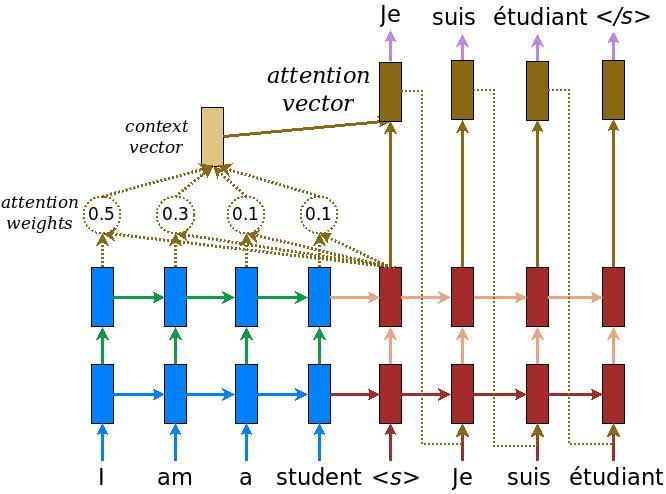

The input is put through an encoder model which gives us the encoder output of shape (batch_size, max_length, hidden_size) and the encoder hidden state of shape (batch_size, hidden_size).

Here are the equations that are implemented:

attention equation 0 attention equation 1

This tutorial uses Bahdanau attention for the encoder. Let's decide on notation before writing the simplified form:

FC = Fully connected (dense) layer
EO = Encoder output
H = hidden state
X = input to the decoder
And the pseudo-code:

score = FC(tanh(FC(EO) + FC(H)))
attention weights = softmax(score, axis = 1). Softmax by default is applied on the last axis but here we want to apply it on the 1st axis, since the shape of score is (batch_size, max_length, hidden_size). Max_length is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
context vector = sum(attention weights * EO, axis = 1). Same reason as above for choosing axis as 1.
embedding output = The input to the decoder X is passed through an embedding layer.
merged vector = concat(embedding output, context vector)
This merged vector is then given to the GRU
The shapes of all the vectors at each step have been specified in the comments in the code:

In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [48]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 7, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [50]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 7, 1)


In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [52]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 5809)


**Define the optimizer and the loss function**

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

**Checkpoints (Object-based saving)**

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

**Training**
1. Pass the input through the encoder which return encoder output and the encoder hidden state.
2. The encoder output, encoder hidden state and the decoder input (which is the start token) is passed to the decoder.
3. The decoder returns the predictions and the decoder hidden state.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use teacher forcing to decide the next input to the decoder.
6. Teacher forcing is the technique where the target word is passed as the next input to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [56]:
EPOCHS = 20

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1 Batch 0 Loss 3.1147
Epoch 1 Batch 100 Loss 1.5515
Epoch 1 Batch 200 Loss 1.5784
Epoch 1 Batch 300 Loss 1.4779
Epoch 1 Batch 400 Loss 1.4549
Epoch 1 Loss 1.5267
Time taken for 1 epoch 82.88764929771423 sec

Epoch 2 Batch 0 Loss 1.2902
Epoch 2 Batch 100 Loss 1.3267
Epoch 2 Batch 200 Loss 1.3675
Epoch 2 Batch 300 Loss 1.3212
Epoch 2 Batch 400 Loss 1.2741
Epoch 2 Loss 1.2988
Time taken for 1 epoch 62.27125024795532 sec

Epoch 3 Batch 0 Loss 1.2043
Epoch 3 Batch 100 Loss 1.2054
Epoch 3 Batch 200 Loss 1.2252
Epoch 3 Batch 300 Loss 1.1863
Epoch 3 Batch 400 Loss 1.1405
Epoch 3 Loss 1.1741
Time taken for 1 epoch 61.994861364364624 sec

Epoch 4 Batch 0 Loss 1.1206
Epoch 4 Batch 100 Loss 1.0988
Epoch 4 Batch 200 Loss 1.0812
Epoch 4 Batch 300 Loss 1.0918
Epoch 4 Batch 400 Loss 1.0203
Epoch 4 Loss 1.0504
Time taken for 1 epoch 62.536519289016724 sec

Epoch 5 Batch 0 Loss 1.0324
Epoch 5 Batch 100 Lo

**Translate**
* The evaluate function is similar to the training loop, except we don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [0]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ') if i in inp_lang.word_index ]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [58]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1544192   
_________________________________________________________________
gru (GRU)                    multiple                  3935232   
Total params: 5,479,424
Trainable params: 5,479,424
Non-trainable params: 0
_________________________________________________________________


In [59]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  1487104   
_________________________________________________________________
gru_1 (GRU)                  multiple                  7080960   
_________________________________________________________________
dense_3 (Dense)              multiple                  5954225   
_________________________________________________________________
bahdanau_attention_1 (Bahdan multiple                  2100225   
Total params: 16,622,514
Trainable params: 16,622,514
Non-trainable params: 0
_________________________________________________________________


In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [0]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

***Restore the latest checkpoint and test***

In [62]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> how are you ? <end>
Predicted translation: i think <end> 


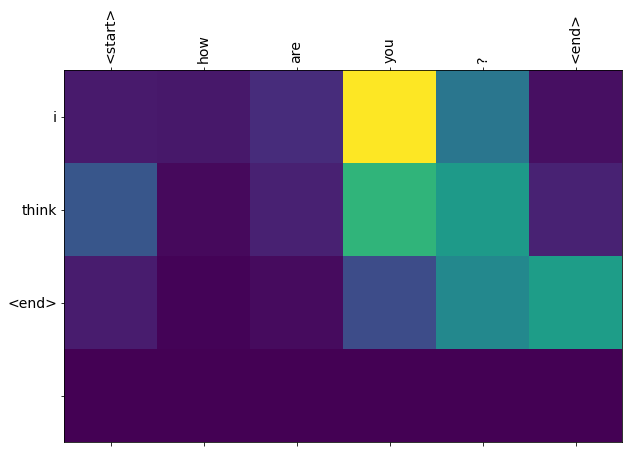

In [64]:
translate('How are you?')

Input: <start> what is your name ? <end>
Predicted translation: what <end> 


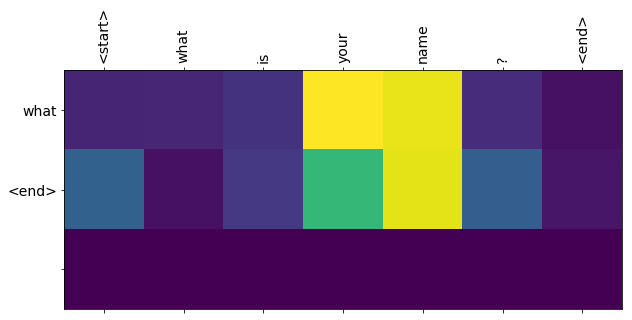

In [65]:
translate('What is your name?')

Input: <start> hey <end>
Predicted translation: hey <end> 


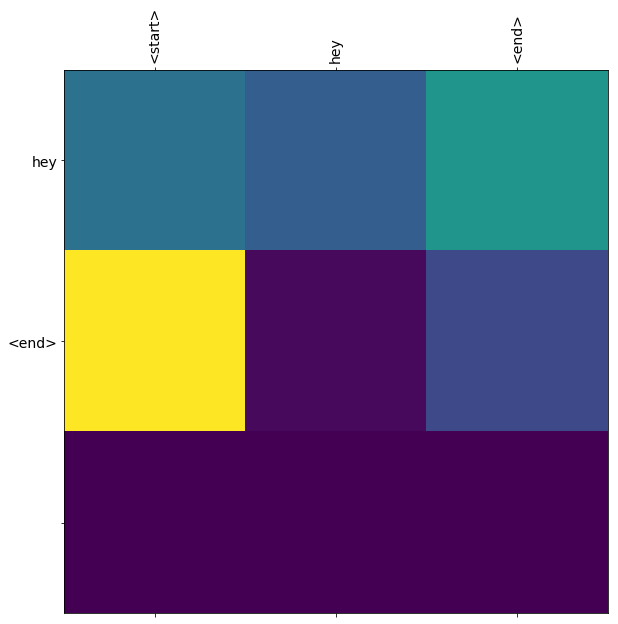

In [66]:
translate('Hey')

Input: <start> good night <end>
Predicted translation: my oh my <end> 


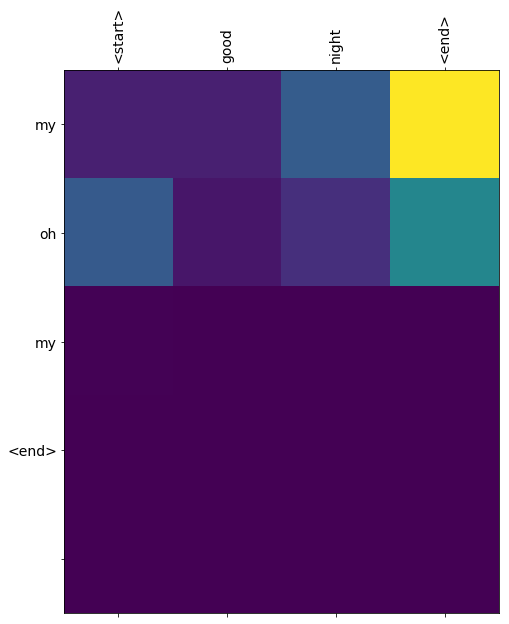

In [69]:
translate('Good night')

Input: <start> i love you <end>
Predicted translation: i know <end> 


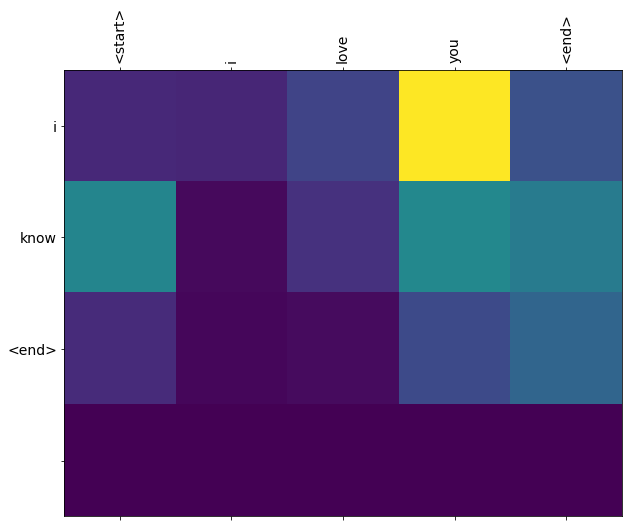

In [70]:
translate('I love you')

Input: <start> where are you ? <end>
Predicted translation: i m dying <end> 


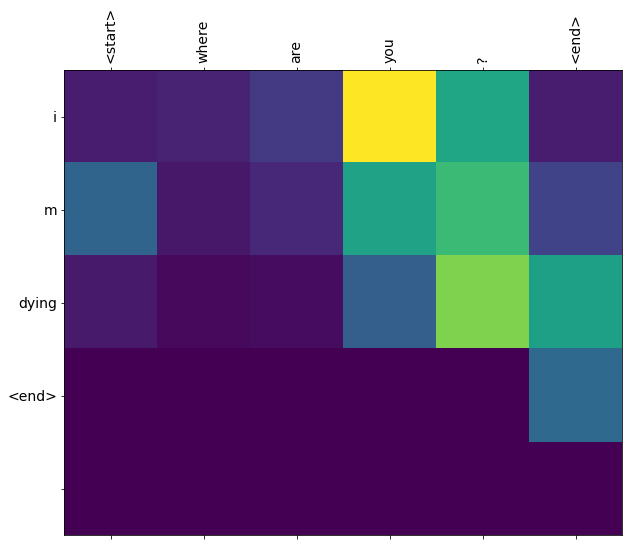

In [71]:
translate('Where are you?')

Input: <start> what are you doing ? <end>
Predicted translation: i see <end> 


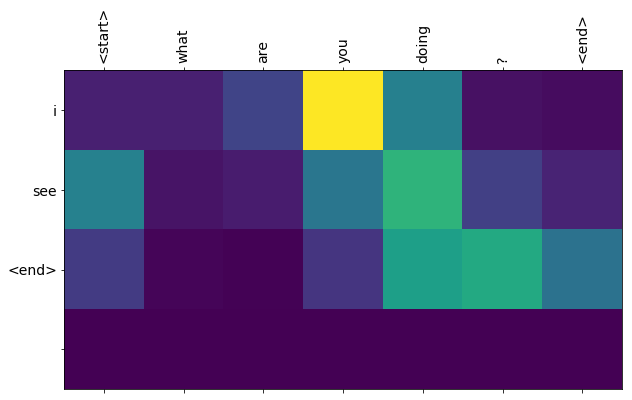

In [72]:
translate('What are you doing?')

Input: <start> good bye <end>
Predicted translation: thank you <end> 


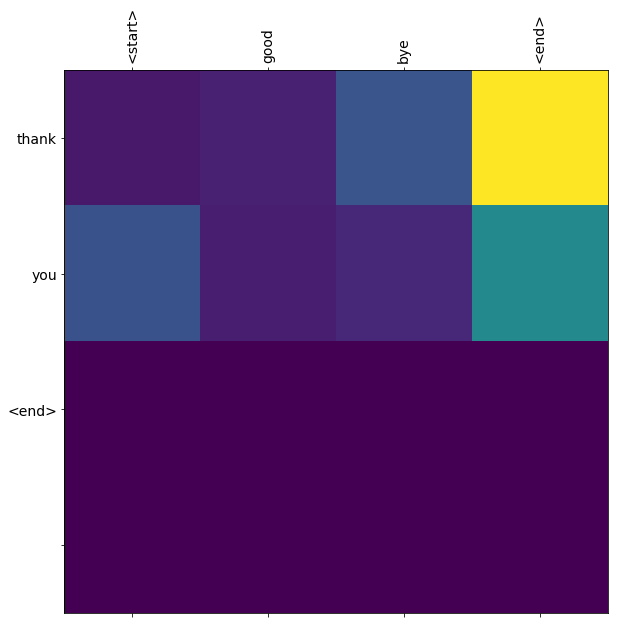

In [75]:
translate('Good bye')

Input: <start> can you help me ? <end>
Predicted translation: afford <end> 


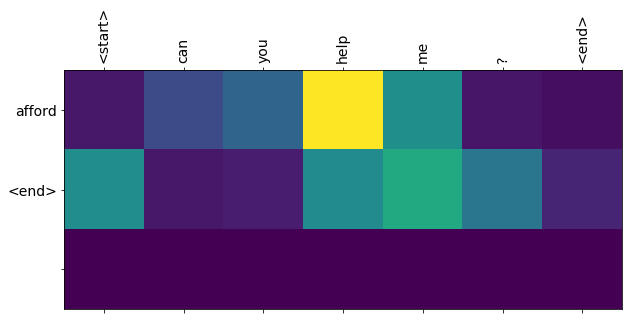

In [76]:
translate('Can you help me?')

Input: <start> will you play with me ? <end>
Predicted translation: i m not <end> 


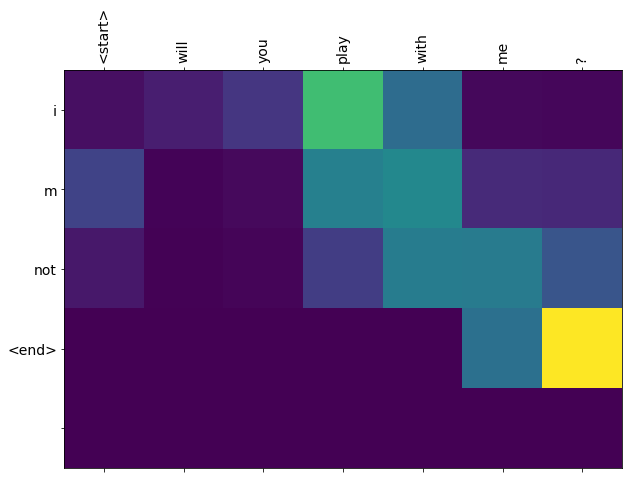

In [77]:
translate('Will you play with me?')

In [0]:
#!ls

In [0]:
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
# # drive.mount('/content/gdrive2')
# drive.flush_and_unmount()

In [0]:
#!cp -r gdrive/My\ Drive/NLP-Honor/training_checkpoints .

In [0]:
# !ls

In [0]:
# !mkdir gdrive/My\ Drive/NLP-Honor

In [0]:
#!cp -r common download_cornell.sh __pycache__ training_checkpoints data download_opensubs.sh sample_data datasets.py example.py setup_google_colab.py gdrive/My\ Drive/NLP-Honor/

In [0]:
# !cp -r training_checkpoints/* gdrive/My\ Drive/NLP-Honor/